データの読み込み・標準化

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv
import math

# 時系列データを一次元配列に格納

data = np.genfromtxt("lorentz-1dim.csv",  # ファイルのパス
)


# 欠損値のインデックスを特定する
nan_indices = np.where(np.isnan(data))

# 欠損値を削除した配列を作成する
data = np.delete(data, nan_indices)

# 平均と標準偏差の計算
mean_value = np.mean(data)
std_dev = np.std(data)

# 標準化
data = (data - mean_value) / std_dev


print('Data length:',data.size)

Data length: 5000


データのグラフ

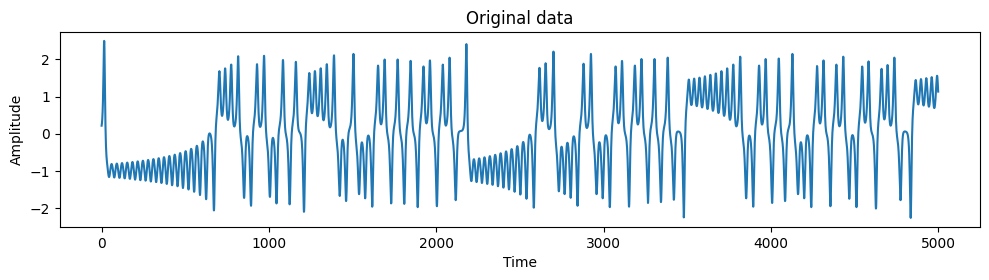

In [9]:
# プロット
plt.figure(figsize=(10, 5))

# 時間領域のプロット
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

フィルタの重み関数

In [10]:
from scipy import signal

class rb_filter:
    def __init__(self, r_p, r_m, c, width, delta_t=1):
        self.t_w = np.arange(-width, 0, delta_t)
        self.weight = (np.sin(self.t_w/r_p)/self.t_w - np.sin(self.t_w/r_m)/self.t_w)* np.sin(self.t_w/c)/(self.t_w/c)
        self.delta_t = delta_t
        self.width = width

        w, self.h = signal.freqz(self.weight) # w: angular frequency, h: response
        self.weight = self.weight / np.max(np.abs(self.h)) # rescale self.weight as the max(h)=0dB

        ##重みの符号がマイナスになっている場合、その符号を反転させる
        max_abs_index = np.argmax(np.abs(self.weight))
        sign = np.sign(self.weight[max_abs_index])
        self.weight = sign * self.weight

    def calc(self, data):
        data_flt = np.zeros_like(data)
        data_flt[:] = np.nan
        for i in range(self.width, data.size):
            data_flt[i] = np.sum(data[i-self.width:i]*self.weight)
        return data_flt


    def timeweight(self):
        return self.t_w, self.weight

フィルタのハイパーパラメータ

In [11]:
# フィルターを設定
#その現象の繰り返し構造（周期）を特定している。

r_p = 100./np.pi # ローパスの周期/π
r_m = 40./np.pi # ハイパスの周期/π
c =  30

width=100

#フィルタのグラフを見ながら、十分にゼロに減衰している範囲で区切る。

T_0=4000 #始点
T_test=300 #始点からのデータの長さ

フィルタの可視化

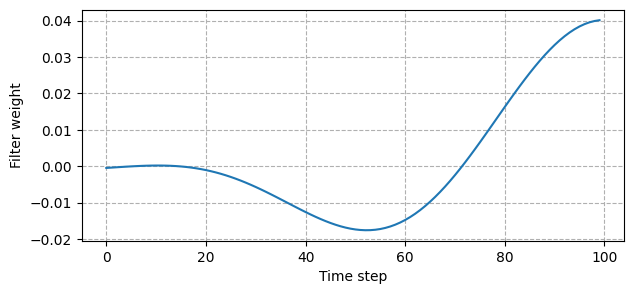

In [12]:
delta_t = 1
filter = rb_filter(r_p, r_m, c, width, delta_t)

t_w, weight = filter.timeweight()
fig = plt.figure(figsize=(7,3), dpi=100)
plt.grid(which='major', linestyle='--', axis='both')
plt.plot(weight[:])
plt.xlabel('Time step')
plt.ylabel('Filter weight')
plt.show()

データにフィルタを適用する

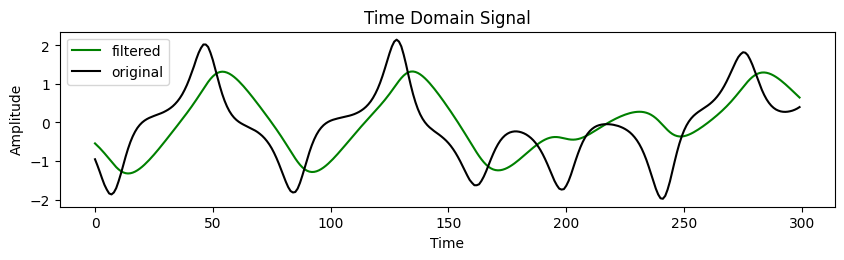

In [13]:
# フィルターを適用
data_flt = filter.calc(data)


fs = data_flt.size  # サンプリング周波数 (Hz)
t = np.arange(0, fs, 1)  # 1秒間のサンプルデータ
data_flt = np.nan_to_num(data_flt, nan=0.0)

# プロット
plt.figure(figsize=(10, 5))

# 時間領域のプロット
plt.subplot(2, 1, 1)
plt.plot(data_flt[T_0:T_0+T_test], color = "green",label="filtered")
plt.plot(data[T_0:T_0+T_test],  color = "black",label="original")
plt.legend()#loc='lower right')
plt.title('Time Domain Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

Time decoder：フィルタデータ(data_flt)からoriginalデータ(data)のスケールへと復元されたものがdata_recovとなる。

ここでは、フィルタをかけたデータそのものを復元しているので、originalデータと完全に一致する。

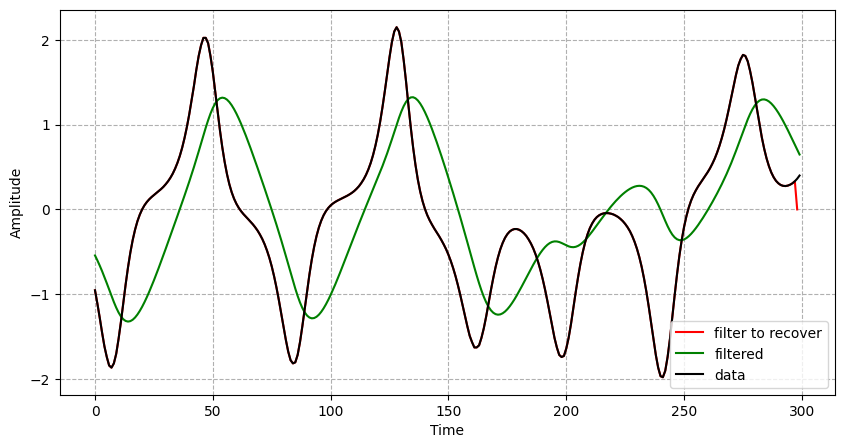

In [14]:
t_w, weights = filter.timeweight()

weights=weights[:-1]


# 時間遅れの配列
data_recov = np.zeros(T_test+width)

for i in range(1,width):
    data_recov[i] = data[i+T_0-width-1]

for i in range(width,T_test+width-1):
    data_recov[i] = ((data_flt[i+T_0-width]- np.dot(weights[0:width-1], data_recov[i-width+1:i]))/weight[width-1])

# テスト予測の実行

plt.figure(figsize=(10, 5))
plt.plot(data_recov[width+1:],  color = "red",label="filter to recover")
plt.plot(data_flt[T_0:T_0+T_test], color = "green",label="filtered")
plt.plot(data[T_0:T_0+T_test], color = "black",label="data")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')


plt.show()